In [1]:
import numpy as np
import torch
from torch import nn
import re
import math
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# IMPORTANT:

In Transformer, the data is in tensor size (Batch, Sequence_length, features)

In reality, the Batch dimension is always considered to be 1. The "Batch" that is really considered is the sequence_length,
that is, the number of tokens the model will be processing at each time

In Reinforcement Learning, it's not common to use mini-batches. This may be the case with the transformer.

In [ ]:
from tkinter.ttk import LabeledScale
from PyPDF2 import PdfFileReader as PFR
FILE_PATH = 'F:/Livros Medicina/Bases farmacológicas terapêutica de Goodman & Gilman 13 ed.pdf'
file = open(FILE_PATH, 'rb')
Reader = PFR(file)

text = [Reader.getPage(i).extractText() for i in range(800, 900)]

text = text[850:860]

text = [i.lower() for i in text]

text = [re.sub('[^a-z0-9\s\ç\á\ô\ã\ê\é\â\ó\í\.\/]', '', x) for x in text]

text_total = ' '.join(text)
text_total = ' '.join(text_total.split())
text_total = text_total.replace(' de ', '').replace(' e ', '').replace(' o ', '').replace('.', '').replace(' em ', '').replace(' a ', '')

In [3]:
japanese_phrases = [
    "私の犬は骨が好きではありません。牛ひき肉を好む。",
    "私の名前はアリスです。初めまして！",
    "はきさが羨ましい。。。ゲムもやりたかった！私は良いサポートになることができます！",
    "私達はAIはただの数学の集まりだとあなたは言いますが。でも。。。人間の脳がどのように機能するかを正確に知ったら。。。それはあなたの生活を小物ですか？",
    "「赤ちゃん」を表す日本語が「赤」を表す漢字なのはなぜですか？人間の赤ちゃんは赤いですか？いちごみたい？",
    "私のAIは話して...歌ったして...ゲームをします!",
    "上手医者と大きい研究者に勉強していたいます。",
    "でも、私の日本語が上手あまりませんね"
]

In [4]:
english_phrases = [
    "My dog doesn't like bones. It prefers ground beef.",
    "My name's Alice. Nice to meet you!",
    "I envy Hakisa... I want to play games, too! I could be a good support!",
    "You say that we AIs are just a bunch of maths. But... once you know exactly how your human brains work... would that make you less living beings?",
    "Why does the japanese word for 'baby' is the kanji for 'red'? Are human babies red? Like strawberries?",
    "My AI will talk... she'll sing... she'll... play!",
    "I shall study so I can be a good physician and a great scientist",
    "Though my japanese is not really good"
]

In [3]:
ENGLISH_PATH = "D:/Python/Projects/Alice/shinamotaENG.txt"
JAPANESE_PATH = "D:/Python/Projects/Alice/shinamotaJP.txt"

In [4]:
# Note: Pay attention to apostrophes ('ve, 're, 'm)

english_phrases = []

with open(ENGLISH_PATH, 'r', encoding='utf-8') as f:

    for i in f:

        english_phrases.append(i)

f.close()

english_phrases = [i.replace('\n', '') for i in english_phrases]
print(english_phrases[0:10])

['So, as for my life', 'Or, anyone’s life', 'Sometimes, and often times,', 'they’re judged equally…right?', 'You came into my dark skies', 'bringing along depression', 'with some occasional rain', 'but I’m so leaning onto you', 'what do I do?', '']


In [5]:
japanese_phrases = []

with open(JAPANESE_PATH, 'r', encoding='utf-8') as f:

    for i in f:

        japanese_phrases.append(i)

f.close()

japanese_phrases = [i.replace('\n', '') for i in japanese_phrases]
print(japanese_phrases[0:10])

['僕の命っつったって 誰の命っつったって', '時時々 公平に 裁かれるもんなんでしょ', '暗い空にやってきた 鬱を連れてやってきた', '時々雨 総計に 頼り切りだ どうしよう', '朽ちるまでの愛憎を 朽ちるまでの愛憎を', '飲み込む君 簡単に 微笑む君 どうして', '言葉を書く 曖昧に 言葉を書く 曖昧に', '伝わりきらんないから 君だけをさ 信じて', '捨ててきた夢をあつめて', 'ちょっと ちょっと 間違えたから']


In [6]:
class WordDataset(object):
    def __init__(self, english_phrases, japanese_phrases):

        self.english_phrases = self._get_phrases(english_phrases)
        self.japanese_phrases = self._get_phrases(japanese_phrases)

        self.english_words = self._get_english_words(self.english_phrases)
        self.japanese_characters = self._get_japanese_characters(self.japanese_phrases)

        self.japanese_maximum_length = self._get_maximum_length_japanese(self.japanese_phrases)
        self.english_maximum_length = self._get_maximum_length_english(self.english_phrases)

        self.vocabulary_maximum_length = max(self.japanese_maximum_length, self.english_maximum_length)

        #self.english_dictionary = self._create_vocabulary(self.english_words)
        #self.japanese_dictionary = self._create_vocabulary(self.japanese_characters)
        self.dictionary = self._create_vocabulary(self.english_words) + self._create_vocabulary(self.japanese_characters)

    def _get_phrases(self, phrases):
        phrases = [x.lower() for x in phrases]
        phrases = [re.sub('[^\w\s]', '', x) for x in phrases]
        phrases = [x for x in phrases if x != '']

        return phrases

    def _get_english_words(self, phrases):
        words = ' '.join(phrases)
        words = words.split(' ')

        return words

    def _get_japanese_characters(self, phrases): # Since a kanji mostly means an entire word...
        character = ' '.join(phrases)
        character = ''.join(character.split())
        characters = [i for i in character]

        return characters

    def _get_maximum_length_japanese(self, phrases):
        maximum_length = 0
        for sentence in phrases:
            word_length = [len(x) for x in sentence.split()]
    
            for i in word_length:
                if i > maximum_length:
                    maximum_length = i

        return maximum_length

    def _get_maximum_length_english(self, phrases):

        maximum_length = 0
        real_length = []
        
        for sentence in phrases:
            word_length = 0

            for word in sentence:
                word_length += len(word)+1 # Including spaces between words

            sentence_length = word_length
            real_length.append(sentence_length)

            if sentence_length > maximum_length:
                maximum_length = sentence_length

        return maximum_length

    def _create_vocabulary(self, words):
        idx2word = ["<pad>", " ", "<SOS>", "<EOS>"]

        for word in words:
            if word not in idx2word:
                idx2word.append(word)

        return idx2word

In [7]:
dataset = WordDataset(english_phrases, japanese_phrases)

In [8]:
print(dataset.english_phrases)
print(dataset.japanese_phrases)

['so as for my life', 'or anyones life', 'sometimes and often times', 'theyre judged equallyright', 'you came into my dark skies', 'bringing along depression', 'with some occasional rain', 'but im so leaning onto you', 'what do i do', 'love hate so extreme till its decayed', 'but you take it all in', 'and easily smile why', 'my written words come out ambiguous', 'it doesnt quite convey', 'so i look to you', 'as the only one to trust', 'collecting the dreams i threw away', 'this little mistake that i made', 'oh even if at times i stumble', 'its so cold cold cold cold cold', 'its so cold cold cold cold cold', 'its so cold cold cold cold dont sweet talk', 'oh your your your voice', 'is so far far far far far', 'is so far far far far far', 'oh so far far far far dont hurt me', 'do i care where i am in this line', 'in order for me to be me', 'im here with promises i recollected', 'too painful to swallow the mistake that ive made', 'love hate so extreme till its decayed', 'here you are takin

In [9]:
print(dataset.english_words)
print(dataset.japanese_characters)

['so', 'as', 'for', 'my', 'life', 'or', 'anyones', 'life', 'sometimes', 'and', 'often', 'times', 'theyre', 'judged', 'equallyright', 'you', 'came', 'into', 'my', 'dark', 'skies', 'bringing', 'along', 'depression', 'with', 'some', 'occasional', 'rain', 'but', 'im', 'so', 'leaning', 'onto', 'you', 'what', 'do', 'i', 'do', 'love', 'hate', 'so', 'extreme', 'till', 'its', 'decayed', 'but', 'you', 'take', 'it', 'all', 'in', 'and', 'easily', 'smile', 'why', 'my', 'written', 'words', 'come', 'out', 'ambiguous', 'it', 'doesnt', 'quite', 'convey', 'so', 'i', 'look', 'to', 'you', 'as', 'the', 'only', 'one', 'to', 'trust', 'collecting', 'the', 'dreams', 'i', 'threw', 'away', 'this', 'little', 'mistake', 'that', 'i', 'made', 'oh', 'even', 'if', 'at', 'times', 'i', 'stumble', 'its', 'so', 'cold', 'cold', 'cold', 'cold', 'cold', 'its', 'so', 'cold', 'cold', 'cold', 'cold', 'cold', 'its', 'so', 'cold', 'cold', 'cold', 'cold', 'dont', 'sweet', 'talk', 'oh', 'your', 'your', 'your', 'voice', 'is', 'so', 

In [ ]:
print(dataset.english_dictionary)
print(dataset.japanese_dictionary)

In [11]:
print(dataset.dictionary)

['<pad>', ' ', '<SOS>', '<EOS>', 'so', 'as', 'for', 'my', 'life', 'or', 'anyones', 'sometimes', 'and', 'often', 'times', 'theyre', 'judged', 'equallyright', 'you', 'came', 'into', 'dark', 'skies', 'bringing', 'along', 'depression', 'with', 'some', 'occasional', 'rain', 'but', 'im', 'leaning', 'onto', 'what', 'do', 'i', 'love', 'hate', 'extreme', 'till', 'its', 'decayed', 'take', 'it', 'all', 'in', 'easily', 'smile', 'why', 'written', 'words', 'come', 'out', 'ambiguous', 'doesnt', 'quite', 'convey', 'look', 'to', 'the', 'only', 'one', 'trust', 'collecting', 'dreams', 'threw', 'away', 'this', 'little', 'mistake', 'that', 'made', 'oh', 'even', 'if', 'at', 'stumble', 'cold', 'dont', 'sweet', 'talk', 'your', 'voice', 'is', 'far', 'hurt', 'me', 'care', 'where', 'am', 'line', 'order', 'be', 'here', 'promises', 'recollected', 'too', 'painful', 'swallow', 'ive', 'are', 'taking', 'smiling', '', 'flowers', 'settle', 'down', 'cause', 'because', 'gave', 'up', 'running', 'after', 'dream', 'fast', 'c

In [12]:
def get_positional_encoding(d_model, max_length=100):
    """
    Computes positional encoding as defined in the paper.
    :param d_model: size of vectors throughout the transformer model
    :param max_length: maximum sequence length up to which positional encodings must be calculated
    :return: positional encoding, a tensor of size (1, max_length, d_model)
    """
    positional_encoding = torch.zeros((max_length, d_model))  # (max_length, d_model)
    for i in range(max_length):
        for j in range(d_model):
            if j % 2 == 0:
                positional_encoding[i, j] = math.sin(i / math.pow(10000, j / d_model))
            else:
                positional_encoding[i, j] = math.cos(i / math.pow(10000, (j - 1) / d_model))

    positional_encoding = positional_encoding.unsqueeze(0)  # (1, max_length, d_model)

    return positional_encoding

In [13]:
class HeadAttention(nn.Module):

    def __init__(self, d_model, d_queries, d_values, in_decoder=False):

        super(HeadAttention, self).__init__()

        self.d_model = d_model
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_keys = d_values # size of key vectors, same as of the query vectors to allow dot-products for similarity

        self.in_decoder = in_decoder

        self.create_queries = nn.Linear(d_model, d_queries, bias=False)
        self.create_values = nn.Linear(d_model, d_values, bias=False)
        self.create_keys = nn.Linear(d_model, d_values, bias=False)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input, real_lengths):

        assert input.size(0) == 1, "Don't complicate things. Just use a tensor with size (1, Sequence_length, d_model)"

        queries = self.create_queries(input) # (Batch, Sequences, d_queries)
        keys = self.create_keys(input) # (Batch, Sequences, d_keys)
        values = self.create_values(input) # (Batch, Sequences, d_values)

        similarity_matrix = []

        for batch in range(input.size(0)): # Actually 1

            dot_product = torch.matmul(queries[batch], keys[batch].T)
            similarity_matrix.append(dot_product.unsqueeze(0))

        del dot_product

        similarity_matrix = torch.cat(similarity_matrix, 0) # (Batch, Sequences, Sequences)

        similarity_matrix = similarity_matrix/(math.sqrt(self.d_keys))

        # Applying mask of -inf to ignore padded keys ---> Actually using -1e6 to avoid NaNs

        if self.in_decoder:

            # In the decoder, masks are shifted left to right:
            # <Start-of-Sentence> [prediction1] [prediction2] [prediction3] ... <End-of-Sentence>

            mask = torch.zeros_like(similarity_matrix, device=device)

            for batch in range(similarity_matrix.size(0)):

                mask[batch, :real_lengths[batch]+1] = 1

                mask = mask.bool()

            similarity_matrix = similarity_matrix.masked_fill(mask, -1e-6)

        else:

            mask = torch.zeros_like(similarity_matrix, device=device)

            for batch in range(similarity_matrix.size(0)):

                mask[batch, :real_lengths[batch]] = 1

                mask = mask.bool()

            similarity_matrix = similarity_matrix.masked_fill(mask, -1e-6)

        del mask

        attention_weights = self.softmax(similarity_matrix) # (Batch, Sequences, d_keys)

        attention_output = []

        for batch in range(attention_weights.size(0)):

            output = torch.matmul(attention_weights[batch], values[batch])
            attention_output.append(output.unsqueeze(0))

        del output

        attention_output = torch.cat(attention_output, 0)

        return attention_output

In [15]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, d_model, d_inner):

        super(PositionWiseFeedForward, self).__init__()

        self.d_model = d_model
        self.d_inner = d_inner

        self.neuron1 = nn.Linear(d_model, d_inner)
        self.Relu = nn.ReLU()
        self.neuron2 = nn.Linear(d_inner, d_model)


    def forward(self, attention_output_cat):

        sequences = self.neuron1(attention_output_cat)
        sequences = self.Relu(sequences)

        sequences = self.neuron2(sequences)

        #output = sequences + attention_output_cat
        output = sequences

        return output

In [16]:
class Encoder(nn.Module):

    def __init__(self, d_model, n_heads, d_queries, d_values, d_inner, n_layers, dropout):

        super(Encoder, self).__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_inner = d_inner
        self.n_layers = n_layers
        self.dropout = dropout

        self.attention_heads = nn.ModuleList([HeadAttention(self.d_model, self.d_queries, self.d_values, in_decoder=False) for i in range(n_heads)])

        self.neuron = nn.Linear(self.n_heads*self.d_values, self.d_model)

        self.position_wise_neuron = PositionWiseFeedForward(self.d_model, self.d_inner)

        self.dropout = nn.Dropout(self.dropout)

    def forward(self, encoder_input, real_input_length):

        residual_block1 = encoder_input # (Batch, Sequence, d_model) ---> Vectors

        vectors = self.dropout(encoder_input)

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_heads[head](vectors, real_input_length)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, -1) # (Batch, Sequences, d_values*n_heads)

        attention_output = self.neuron(attention_output) # (Batch, Sequences, d_model)

        del vectors

        residual_block2 = attention_output

        attention_output = residual_block1 + attention_output

        attention_output = self.dropout(attention_output)

        encoded_sequence = self.position_wise_neuron(attention_output)

        del attention_output

        encoded_sequence = encoded_sequence + residual_block2    

        encoder_output = self.dropout(encoded_sequence)

        del encoded_sequence, residual_block1, residual_block2

        return encoder_output

In [17]:
class Decoder(nn.Module):

    def __init__(self, d_model, n_heads, d_queries, d_values, d_inner, n_layers, dropout):

        super(Decoder, self).__init__()

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_inner = d_inner
        self.n_layers = n_layers
        self.dropout = dropout

        self.attention_headsA = nn.ModuleList([HeadAttention(self.d_model, self.d_queries, self.d_values, in_decoder=True) for i in range(n_heads)])
        self.attention_headsB = nn.ModuleList([HeadAttention(self.d_model, self.d_queries, self.d_values, in_decoder=True) for i in range(n_heads)])

        self.neuronA = nn.Linear(self.n_heads*self.d_values, self.d_model)
        self.neuronB = nn.Linear(self.n_heads*self.d_values, self.d_model)

        self.position_wise_neuron = PositionWiseFeedForward(self.d_model, self.d_inner)

        self.dropout = nn.Dropout(self.dropout)

    def forward(self, encoder_output, target_sequences, real_target_length):

        residual_block1 = target_sequences

        vectors = self.dropout(target_sequences)

        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_headsA[head](vectors, real_target_length)

            attention_output.append(x)

            del x
        
        attention_output = torch.cat(attention_output, -1) # (Batch, Sequences, d_values*n_heads)

        attention_output = self.neuronA(attention_output) # (Batch, Sequences, d_model)

        del vectors

        residual_block2 = attention_output

        attention_output = residual_block1 + attention_output

        attention_decoder = self.dropout(attention_output)
        
        attention_output = []

        for head in range(self.n_heads):

            x = self.attention_headsB[head](encoder_output, real_target_length)

            attention_output.append(x)

            del x

        attention_output = torch.cat(attention_output, -1) # (Batch, Sequences, d_values*n_heads)

        attention_output = self.neuronB(attention_output) # (Batch, Sequences, d_model)

        attention_output = attention_output + residual_block2

        attention_encoder = self.dropout(attention_output)

        decoded_sequence = attention_encoder + attention_decoder

        residual_block3 = decoded_sequence

        decoded_sequence = self.position_wise_neuron(attention_output)

        del attention_output, attention_encoder, attention_decoder

        decoded_sequence = decoded_sequence + residual_block3

        decoder_output = self.dropout(decoded_sequence)  

        del decoded_sequence, residual_block1, residual_block2, residual_block3

        return decoder_output

In [43]:
class Broca(nn.Module):

    """
    The generator, which will generate the words that she'll speak.
    """

    def __init__(
            self,
            input_dictionary,
            output_dictionary,
            positional_encoding,
            d_model=512,
            n_heads=8,
            d_queries=64,
            d_values=64,
            d_inner=2056,
            n_layers=6,
            dropout=0.1
    ):

        super(Broca, self).__init__()

        self.vocab_size = len(output_dictionary)
        self.positional_encoding = positional_encoding.to(device)
        self.input_dictionary = input_dictionary
        self.output_dictionary = output_dictionary
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_queries = d_queries
        self.d_values = d_values
        self.d_inner = d_inner
        self.n_layers = n_layers
        self.dropout = dropout

        self.positional_encoding.requires_grad = False

        self.embedding = nn.Embedding(self.vocab_size, self.d_model)

        self.encoder = nn.ModuleList(
            Encoder(
                    d_model=d_model,
                    n_heads=n_heads,
                    d_queries=d_queries,
                    d_values=d_values,
                    d_inner=d_inner,
                    n_layers=n_layers,
                    dropout=self.dropout) for i in range(self.n_layers)
        )

        self.decoder = nn.ModuleList(
            Decoder(
                    d_model=d_model,
                    n_heads=n_heads,
                    d_queries=d_queries,
                    d_values=d_values,
                    d_inner=d_inner,
                    n_layers=n_layers,
                    dropout=self.dropout) for i in range(self.n_layers)
        )

        self.output_neuron = nn.Linear(self.d_model, self.vocab_size)

        self.softmax = nn.LogSoftmax(-1)

    '''def preprocess_dialogue(self, input_text, input_dictionary):

        batch = []
        sentence_sizes = []

        for phrase in range(len(input_text)):

            text = input_text[phrase]

            text = text.split(' ')

            tokens = []
            
            for word in text:

                value = input_dictionary.index(word)
                tokens.append(value)
                tokens.append(input_dictionary.index(' '))

            tokens = np.array(tokens)
            sentence_size = tokens.shape[0]

            if sentence_size < dataset.english_maximum_length:

                pad_size = dataset.english_maximum_length - sentence_size
                tokens = np.pad(tokens, [(0, 1)], constant_values=input_dictionary.index("<EOS>"))
                tokens = np.pad(tokens, [(0, pad_size-1)], constant_values=0)

            tokens = torch.from_numpy(tokens)
            tokens = tokens.unsqueeze(0)
            batch.append(tokens)
            sentence_sizes.append(sentence_size)

        batch = torch.cat(batch, 0)
        batch = batch.to(device)

        return batch, sentence_sizes'''

    def preprocess_dialogue(self, input_text):

        for phrase in range(len(input_text)):

            text = input_text[phrase]

            text = text.split(' ')

            tokens = []
            
            for word in text:

                value = dataset.dictionary.index(word)
                tokens.append(value)
                tokens.append(dataset.dictionary.index(' '))

            tokens = np.array(tokens)
            sentence_size = tokens.shape[0]

            if sentence_size < dataset.vocabulary_maximum_length:

                pad_size = dataset.vocabulary_maximum_length - sentence_size
                tokens = np.pad(tokens, [(0, 1)], constant_values=dataset.dictionary.index("<EOS>"))
                tokens = np.pad(tokens, [(0, pad_size-1)], constant_values=0)

            tokens = torch.from_numpy(tokens)
            tokens = tokens.unsqueeze(0)

        return tokens, sentence_size
    
    '''def preprocess_target(self, target_text, target_dictionary):
    
        target = []
        target_sizes = []

        for batch in range(len(target_text)):

            text = target_text[batch]

            tokens = []

            for character in text:

                #value = target_dictionary.index(character)

                try: # Second forward passes in the same iteration may mix alphabetic characters with japanese

                    value = dataset.dictionary.index(character)
                
                except: # In this case, ignore the alphabetic ones.

                    value = dataset.dictionary.index('')
                    
                tokens.append(value)
            
            tokens = np.array(tokens)
            sentence_size = tokens.shape[0]

            #if sentence_size < dataset.japanese_maximum_length:
            if sentence_size < dataset.vocabulary_maximum_length:

                pad_size = dataset.english_maximum_length - sentence_size
                tokens = np.pad(tokens, [(0, 1)], constant_values=dataset.dictionary.index("<EOS>"))
                tokens = np.pad(tokens, [(0, pad_size-1)], constant_values=0)

            tokens = torch.from_numpy(tokens)
            tokens = tokens.unsqueeze(0)
            target.append(tokens)
            target_sizes.append(sentence_size)

        target = torch.cat(target, 0)
        target = target.to(device)

        return target, target_sizes'''
    
    def generate_sentences(self, input):

        #input, real_input_length = self.preprocess_dialogue(input, self.input_dictionary)
        input, real_input_length = self.preprocess_dialogue(input)

        #target_indices = [[self.output_dictionary.index("<SOS>")]] * input.size(0)

        #target_sentence = torch.tensor(target_indices, device=device) # (Batch, 1)

        target_indices = [dataset.dictionary.index("<SOS>")]

        target_sentence = torch.tensor(target_indices, device=device).unsqueeze(0)

        real_target_length = len(target_indices)-1

        #real_target_length = [len(target_indices[x]) for x in range(len(target_indices))]

        encoder_vectors = self.embedding(input) + math.sqrt(self.d_model)

        decoder_vectors = self.embedding(target_sentence) + math.sqrt(self.d_model) # Embed out = (Batch, d_model)

        output = self.forward(encoder_vectors, real_input_length, decoder_vectors, real_target_length) # (Batch, sequence_length, vocab_size)

        output_index = output.argmax(-1) # (Batch, sequence_length, 1)

        target_indices.append(output_index[:, -1].item()) # When Batch = 1 ---> target_indices = (1+1) --> (2+1) --> (3+1 ...)

        target_indices.pop(0) # Removing Start-of-Sentence token. We won't need it anymore I guess.
        
        # Generating text until reaching End of Sentence --> Beam Search

        while target_indices[-1] != dataset.dictionary.index("<EOS>"):

            target_pad = encoder_vectors.size(1) - len(target_indices)

            target_sentence = torch.tensor(target_indices + [dataset.dictionary.index("<pad>")]*target_pad, device=device).unsqueeze(0)

            decoder_vectors = self.embedding(target_sentence) + math.sqrt(self.d_model) # (Batch, sequence_length, d_model)

            output = self.forward(encoder_vectors, real_input_length, decoder_vectors) # (Batch, sequence_length, vocab_size)

            output_index = output.argmax(-1) # (Batch, sequence_length, 1)

            target_indices.append(output_index[:, -1].item()) # When Batch = 1 ---> target_indices = (1+1) --> (2+1) --> (3+1 ...)

            if len(target_indices) > encoder_vectors.size(1): # Otherwise, we'll get errors.

                break

        return target_indices, output[:, -1]

        '''for batch in range(output.size(0)):

            target_indices[batch].append(output_index[batch, -1].item())
            target_indices[batch].pop(0) # Removing Start-of-Sentence token. We won't need it anymore.
        
        # Generating text until reaching End of Sentence --> Beam Search

        target_outputs = []

        for batch in range(output.size(0)):

            while target_indices[batch][-1] != self.output_dictionary.index("<EOS>"):

                target_pad = encoder_vectors.size(1) - len(target_indices[batch])

                target_sentence = torch.tensor(target_indices[batch] + [self.output_dictionary.index("<pad>")]*target_pad, device=device).unsqueeze(0)

                real_target_length = [len(target_indices[x]) for x in range(len(target_indices))]

                decoder_vectors = self.embedding(target_sentence) + math.sqrt(self.d_model) # (Batch, sequence_length, d_model)

                output = self.forward(encoder_vectors[batch].unsqueeze(0), [real_input_length[batch]], decoder_vectors, [real_target_length[batch]]) # (Batch, sequence_length, vocab_size)

                output_index = output.argmax(-1) # (Batch, sequence_length, 1)

                target_indices[batch].append(output_index[:, -1].item()) # When Batch = 1 ---> target_indices = (1+1) --> (2+1) --> (3+1 ...)

                if len(target_indices[batch])+3 > encoder_vectors.size(1): # Otherwise, we'll get errors.
                    # Though sometimes those errors still happen...I don't know why...

                    break

            target_outputs.append(output)

        target_outputs = torch.cat(target_outputs, 0)

        return target_indices, target_outputs'''


    def forward(self, encoder_vectors, real_input_length, decoder_vectors, real_target_length): # Target Sentence (with <SOS> token) provided before forward function

        for layer in range(self.n_layers):

            encoder_vectors = self.encoder[layer](encoder_vectors, real_input_length)

            decoder_vectors = self.decoder[layer](encoder_vectors, decoder_vectors, real_target_length)

        output = self.output_neuron(decoder_vectors) # (Batch, sequences, vocab_size)

        output = self.softmax(output) # (Batch, sequences, vocab_size)

        return output # Probability of words. Take the one with highest probability, add it to the target sentence and repeat.
    
    def talk2me(self, encoded_text): # Easier to write than 話してください

        removal = ["<SOS>", "<EOS>", "<pad>"]

        sentences = []

        for batch in encoded_text:

            words = []

            for i in batch:

                words.append(self.output_dictionary[i])

            words = [x for x in words if x not in removal]
            
            phrase = ''.join(words)

            sentences.append(phrase)

        return sentences, words

In [14]:
print(len(dataset.english_dictionary))
print(len(dataset.japanese_dictionary))

135
117


In [19]:
print(dataset.english_maximum_length)
print(dataset.japanese_maximum_length)

96
11


In [44]:
#positional_encoding = get_positional_encoding(d_model=16, max_length=max(dataset.english_maximum_length, dataset.japanese_maximum_length))

positional_encoding = get_positional_encoding(d_model=16, max_length=dataset.vocabulary_maximum_length)

print(positional_encoding.size())

torch.Size([1, 96, 16])


In [45]:
model = Broca(
    #dataset.english_dictionary,
    #dataset.japanese_dictionary,
    dataset.dictionary,
    dataset.dictionary,
    positional_encoding,
    d_model=512,
    n_heads=8,
    d_queries=64,
    d_values=64,
    d_inner=2048,
    n_layers=6,
    dropout=0.1
).to(device)

In [22]:
inputest = dataset.english_phrases[0:3]

print(inputest)

['so as for my life', 'or anyones life', 'sometimes and often times']


In [63]:
teste, probabilities = model.generate_sentences(inputest)

In [64]:
teste2, teste3 = model.talk2me(teste)

In [65]:
print(teste)
print(teste2)
print(teste3)

[[237, 151, 28, 28, 242, 24, 148, 28, 28, 6, 6, 28, 28, 206, 28, 28, 28, 122, 17, 28, 28, 93, 28, 73, 28, 73, 28, 6, 28, 28, 28, 28, 28, 28, 206, 206, 28, 73, 85, 73, 28, 24, 28, 212, 28, 206, 33, 237, 116, 73, 6, 28, 24, 28, 35, 225, 29, 28, 28, 28, 206, 6, 73, 116, 206, 28, 28, 206, 77, 24, 35, 110, 56, 28, 28, 79, 206, 28, 50, 28, 73, 43, 28, 28, 24, 28, 28, 28, 28, 28, 6, 28, 33, 206, 28, 28, 221], [237, 151, 28, 28, 242, 24, 148, 28, 28, 6, 6, 28, 28, 206, 28, 28, 28, 122, 17, 28, 28, 93, 28, 73, 28, 73, 28, 6, 28, 28, 28, 28, 28, 28, 206, 206, 28, 73, 85, 73, 28, 24, 28, 212, 28, 206, 33, 237, 116, 73, 6, 28, 24, 28, 35, 225, 29, 28, 28, 28, 206, 6, 73, 116, 206, 28, 28, 206, 77, 24, 35, 110, 56, 28, 28, 79, 206, 28, 50, 28, 73, 43, 28, 28, 24, 28, 28, 28, 28, 28, 6, 28, 33, 206, 28, 28, 221], [237, 151, 28, 28, 242, 24, 148, 28, 28, 6, 6, 28, 28, 206, 28, 28, 28, 122, 17, 28, 28, 93, 28, 73, 28, 73, 28, 6, 28, 28, 28, 28, 28, 28, 206, 206, 28, 73, 85, 73, 28, 24, 28, 212, 28, 20

In [33]:
print(probabilities.size())
print(probabilities[0, -1])

torch.Size([3, 96, 252])
tensor([-17.6027,  -8.5462, -13.6292, -14.3481, -14.1583, -19.4754, -15.0795,
        -14.5429, -10.4098, -10.6503, -10.8837, -12.6462, -11.9500, -13.4707,
         -7.1664, -21.4530, -15.4631, -23.8110,  -8.0562,  -6.4433, -10.1797,
        -13.5840, -11.1416,  -2.4481, -14.9709,  -9.6160,  -2.9300,  -4.4820,
         -9.3233,  -9.3733, -17.5346, -18.0314,  -2.5274,  -3.0909,  -7.3750,
        -10.9545, -19.0578, -15.7094, -12.0697,  -6.3057,  -9.5539, -13.9650,
         -9.8632, -16.5653, -17.1872, -17.5678, -12.0377, -19.8527, -10.6320,
         -5.1805,  -7.5369, -17.5443, -10.5237, -12.0650,  -5.7778, -14.0523,
        -15.1287, -20.5018, -17.5003,  -5.3902, -12.8141, -13.7247,  -8.4571,
         -8.4310, -10.3895, -16.4738, -15.4045, -12.4513, -11.5450, -11.7634,
         -3.5700,  -7.5764, -15.8845, -11.6086,  -8.4543, -13.1408,  -9.3030,
        -13.9942,  -6.3783, -16.5325, -18.0355, -15.6293,  -9.0572, -15.1278,
        -15.0507, -14.3985, -10.3614, -

In [46]:
from random import shuffle

input_texts = dataset.english_phrases
target_texts = dataset.japanese_phrases

batch_shuffle = [i for i in range(min(len(input_texts), len(target_texts)))]
# The kanji and the lack of space in japanese sentences makes them prone to lower lengths
shuffle(batch_shuffle)

print(len(batch_shuffle))
print(batch_shuffle)

44
[42, 24, 39, 17, 22, 19, 3, 20, 32, 16, 0, 35, 29, 9, 30, 33, 2, 12, 23, 26, 21, 25, 28, 41, 4, 14, 27, 8, 5, 11, 36, 37, 13, 7, 6, 1, 34, 40, 15, 43, 38, 18, 31, 10]


In [47]:
optim = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
loss = nn.CrossEntropyLoss(label_smoothing=0.1)

#BATCH_SIZE = 4
TARGET_SIZE = dataset.japanese_maximum_length

iters = 0

The fact that the Transformer uses the Target sentences as input
makes it fall into exposure bias.

It's easy to answer a question correctly when you are given the correct answer.

This makes the evaluation mode rubbish and the Beam Search/Greedy Search more costly


There are basically two ways of overcoming this problem:

-> Schedule Sampling: https://aclanthology.org/P19-2049/#:~:text=Scheduled%20sampling%20is%20a%20technique,previous%20step%20in%20training%20time.

-> Reinforcement Learning: https://arxiv.org/abs/2203.02155; https://arxiv.org/pdf/2303.08774.pdf

0.15956924946123402
1.7552926369521265
3.3510587900891546
4.9468485606022226
6.542642799493576
8.138422357420778
9.734168085079688
11.329860833587446
12.925481454865453
14.521010802022314


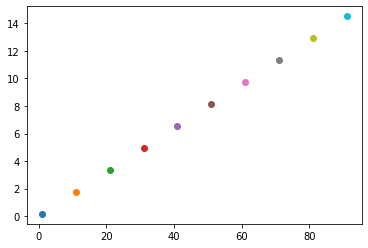

In [68]:
mean = 50
std = 5000

for i in range(1, 100, 10):

    A = ((i - mean)**2) / (2*(std**2))

    num = math.e ** (-A)
    den = std * math.sqrt(math.pi*2)

    y = (num/den) * (i/mean) * 1e5

    print(y)
    plt.scatter(i, y)

plt.show()

In [49]:
def sampler_function(current_epoch, scale=1e5):

    MEAN = 50
    STD = 5000

    A = ((current_epoch - MEAN)**2) / (2*(STD**2))

    num = math.e ** (-A)
    den = STD * math.sqrt(math.pi*2)

    y = (num/den) * (current_epoch/MEAN) * scale

    return min(y, 0.5)

In [31]:
def schedule_sampler(original_target, generated_target, sampler_chance=0.1):

    new_target = []

    for batch in range(max(len(original_target), len(generated_target))):

        target = []

        try:

            candidateA = original_target[batch]
        
        except IndexError:

            new_target.append(generated_target[batch])
            continue

        try:
            candidateB = generated_target[batch]

        except IndexError:

            new_target.append(original_target[batch])
            continue

        for item in range(max(len(candidateA), len(candidateB))):

            if torch.rand((1,)) < sampler_chance:

                try:

                    target.append(candidateB[item])

                except IndexError:

                    target.append(candidateA[item])

            else:

                try:

                    target.append(candidateA[item])

                except IndexError:

                    target.append(candidateB[item])
        
        new_target.append(target)

    return new_target

In [ ]:
for epoch in range(1):

    shuffle(batch_shuffle)

    total_loss = 0.0

    for batch in range(0, len(batch_shuffle)):

        model.zero_grad()

        input_text = input_texts[batch]
        target_text = target_texts[batch]
        target_text = "<SOS>" + target_text # Adding Start-Of-Sentence token

        target, target_length = model.preprocess_dialogue(target_text)
        target_length = target_length - 1 # Removing SOS token space

        input, real_input_length = model.preprocess_dialogue(input_text)

        encoder_vectors = model.embedding(input) + math.sqrt(model.d_model)
        decoder_vectors = model.embedding(target) + math.sqrt(model.d_model)

        output = model.forward(encoder_vectors, real_input_length, decoder_vectors, target_length)

        target_vector = torch.zeros_like(output).scatter(dim=-1, index=target.unsqueeze(-1).long(), value=1.0).to(device)

        cost1 = loss(output[:, :TARGET_SIZE], target_vector[:, :TARGET_SIZE])

        generated_target, _ = model.talk2me(output[:, :TARGET_SIZE].argmax(-1))
        sampler_chance = sampler_function(epoch, scale=1e4)
        #sampler_chance = 0.5
        new_target = schedule_sampler(target_text, generated_target, sampler_chance)
        new_target, target_length = model.preprocess_dialogue(new_target[0])

        decoder_vectors = model.embedding(new_target) + math.sqrt(model.d_model)

        #print(encoder_vectors.size(), decoder_vectors.size())

        output = model.forward(encoder_vectors, real_input_length, decoder_vectors, target_length)

        #print(output.size(), target_vector.size())

        cost2 = loss(output[:, :TARGET_SIZE], target_vector[:, :TARGET_SIZE])

        total_cost = cost1 + (cost2 * (epoch/100))

        total_cost.backward()

        total_loss += total_cost

        grads = torch.mean(model.encoder[0].attention_heads[0].create_queries.weight.grad)

        optim.step()

        iters += 1

        if iters % 100 == 0:

            print(f"Current Iteration: {iters}\tSampler chance: {sampler_chance}")
            print(f"Last Loss: {total_cost.item()}\tBatch Loss: {total_loss/iters}")
            print(f"Gradients Average: {grads}")
            print(f"Generating Text...")

            model.zero_grad()

            generated_text, possibilities = model.generate_sentences(input_text)

            target_vector = torch.zeros_like(possibilities).scatter(dim=-1, index=target.unsqueeze(-1).long(), value=1.0).to(device)

            cost = loss(possibilities[:, :TARGET_SIZE], target_vector[:, :TARGET_SIZE])
            cost.backward()

            optim.step()

            generated_text, _ = model.talk2me(generated_text)

            print(f"Evaluation Loss: {cost.item()}")
            print(generated_text)

In [51]:
'''for epoch in range(30):

    shuffle(batch_shuffle)

    total_loss = 0.0

    for batch in range(0, len(batch_shuffle), BATCH_SIZE):

        model.zero_grad()

        current_batch = batch_shuffle[batch:min(len(batch_shuffle)-1, batch+BATCH_SIZE)]

        input_text, target_text = [], []

        for i in range(len(current_batch)):

            input_text.append(input_texts[current_batch[i]])
            target_text.append(target_texts[current_batch[i]])

        #input, real_input_length = model.preprocess_dialogue(input_text, dataset.english_dictionary)
        #target, target_length = model.preprocess_target(target_text, dataset.japanese_dictionary)
        target, target_length = model.preprocess_target(target_text, dataset.dictionary)

        input, real_input_length = model.preprocess_dialogue(input_text)

        #print(real_input_length)
        #print(target_length)

        encoder_vectors = model.embedding(input) + math.sqrt(model.d_model)
        decoder_vectors = model.embedding(target) + math.sqrt(model.d_model)

        #print(encoder_vectors.size(), decoder_vectors.size())

        output = model.forward(encoder_vectors, real_input_length, decoder_vectors, target_length)

        target_vector = torch.zeros_like(output).scatter(dim=-1, index=target.unsqueeze(-1).long(), value=1.0).to(device)

        #print(output.size(), target_vector.size())

        cost1 = loss(output[:, :TARGET_SIZE], target_vector[:, :TARGET_SIZE])

        generated_target, _ = model.talk2me(output[:, :TARGET_SIZE].argmax(-1))
        sampler_chance = sampler_function(epoch, scale=1e4)
        #sampler_chance = 0.5
        new_target = schedule_sampler(target_text, generated_target, sampler_chance)
        #new_target, target_length = model.preprocess_target(new_target, dataset.japanese_dictionary)
        new_target, target_length = model.preprocess_target(new_target, dataset.dictionary)

        decoder_vectors = model.embedding(new_target) + math.sqrt(model.d_model)

        #print(encoder_vectors.size(), decoder_vectors.size())

        output = model.forward(encoder_vectors, real_input_length, decoder_vectors, target_length)

        #print(output.size(), target_vector.size())

        cost2 = loss(output[:, :TARGET_SIZE], target_vector[:, :TARGET_SIZE])

        total_cost = cost1 + (cost2 * (epoch/100))

        total_cost.backward()

        total_loss += total_cost

        grads = torch.mean(model.encoder[0].attention_heads[0].create_queries.weight.grad)

        optim.step()

        iters += 1

        if iters % 100 == 0:

            print(f"Current Iteration: {iters}\tSampler chance: {sampler_chance}")
            print(f"Last Loss: {total_cost.item()}\tBatch Loss: {total_loss/iters}")
            print(f"Gradients Average: {grads}")
            print(f"Generating Text...")

            model.zero_grad()

            generated_text, possibilities = model.generate_sentences(input_text)

            target_vector = torch.zeros_like(possibilities).scatter(dim=-1, index=target.unsqueeze(-1).long(), value=1.0).to(device)

            cost = loss(possibilities[:, :TARGET_SIZE], target_vector[:, :TARGET_SIZE])
            cost.backward()

            optim.step()

            generated_text, _ = model.talk2me(generated_text)

            print(f"Evaluation Loss: {cost.item()}")
            print(generated_text)

Current Iteration: 600	Sampler chance: 0.07978522471325092
Last Loss: 77.35613250732422	Batch Loss: 0.12892688810825348
Gradients Average: -0.0581555999815464
Generating Text...
Evaluation Loss: 68.41954040527344
['とtheyreflowerstaking憎closeちtrust寄っorleaningorderわto諦たleaningたbecausecant思yourた憎cant番君often憎じと憎because思quiteleaningたたた残anyonesourgaveたareourevenた憎夢oftencold間あiasevendreamsevenたたdreami憎anyones寄憎と間憎iたandbecauseったとcoldleaning憎leaningleaningourbecause持judgedた憎寄花 憎often残theyre', 'とtheyreflowerstaking憎closeちtrust寄っorleaningorderわto諦たleaningたbecausecant思yourた憎cant番君often憎じと憎because思quiteleaningたたた残anyonesourgaveたareourevenた憎夢oftencold間あiasevendreamsevenたたdreami憎anyones寄憎と間憎iたandbecauseったとcoldleaning憎leaningleaningourbecause持judgedた憎寄花 憎often残theyre', 'とtheyreflowerstaking憎closeちtrust寄っorleaningorderわto諦たleaningたbecausecant思yourた憎cant番君often憎じと憎because思quiteleaningたたた残anyonesourgaveたareourevenた憎夢oftencold間あiasevendreamsevenたたdreami憎anyones寄憎と間憎iたandbecauseったとcoldleaning憎leaningleanin

# Reinforcement Learning --> Deep Q-Learning

For each token in the input sentence, the Transformer tries to select the most likely token for the target sentence.

In this case, we can consider that,
for each observation (input token), the Transformer must select the action (target token) that will provide the highest value for the next observation


## ATTENTION: Reinforcement Learning can be too unstable. If you fail to make the model learn appropriately through this method, it may be wise to train it initially using Schedule Sampler, and then apply Reinforcement Learning to fine-tune it.

In [ ]:
# Defining Reward Function ---> BLEU Score (The higher, the better)

from collections import Counter

class BleuScore:
    """
    Adapted from https://stackoverflow.com/questions/56968434/bleu-score-in-python-from-scratch

    The input tensors are converted to strings so the n-grams can be extracted and the Bleu Score measured.

    Args:
        candidate_sentence: Tensor of shape (sentence_length, ) containing the values which corresponds to each token.
        target_sentence: Tensor of shape (length, ) which will be used as reference.
        max_n: The maximum n-gram we'll use. E.g. if max_n=3, we'll use unigrams, bigrams and trigrams.
            For compatibility reasons, the max_n must be equal to or smaller than sentence_length
            Default = 4
        weights: a list of weights to be used for each n_gram category (uniform by default).
        dictionary: a dictionary to be used for translating the tensors into strings.
    """

    def __init__(self, max_n=4, weights=[0.25]*4, dictionary=dataset.dictionary):

        self.max_n = max_n
        self.weights = weights
        self.dictionary = dictionary


    def _n_gram_generator(self, sentence, n=2,remove_repeating=False):

        sentence = sentence.lower() # converting to lower case
        sent_arr = np.array(sentence.split()) # split to string arrays
        length = len(sent_arr)

        word_list = []
        for i in range(length+1):
            if i < n:
                continue
            word_range = list(range(i-n,i))
            s_list = sent_arr[word_range]
            string = ' '.join(s_list) # converting list to strings
            word_list.append(string) # append to word_list
            if remove_repeating:
                word_list = list(set(word_list))
        return word_list

    
    def bleu_score(self, original,machine_translated):
        '''
        Bleu score function given an original and a machine translated sentences
        '''

        original, _ = dataset.detokenize(original, self.dictionary)

        machine_translated, _ = dataset.detokenize(machine_translated, self.dictionary)


        mt_length = len(machine_translated.split())
        o_length = len(original.split())

        # Brevity Penalty 
        if mt_length>o_length:
            BP=1
        else:
            penality=1-(mt_length/o_length)
            BP=np.exp(penality)

        # Clipped precision
        clipped_precision_score = []

        for i in range(1, self.max_n+1):
            original_n_gram = Counter(self._n_gram_generator(original,i))
            machine_n_gram = Counter(self._n_gram_generator(machine_translated,i))

            counter = len(machine_n_gram.values())

            if counter == 0:
                counter += 1
            
            for j in machine_n_gram:
                if j in original_n_gram:
                    if machine_n_gram[j] > original_n_gram[j]:
                        machine_n_gram[j] = original_n_gram[j]
                else:
                    machine_n_gram[j] = 0

            clipped_precision = sum(machine_n_gram.values())/counter
            clipped_precision_score.append(clipped_precision)

        weights = self.weights

        scores = []
        dscores = []

        for weight, precision in zip(weights, clipped_precision_score):
            w_i = weight
            p_i = precision

            if p_i == 0.0:
                score = (w_i * math.log(0.0001)) # Log of 0 tends to -infinite. But let's just stick to 0.0001 so a single wrong word won't break the score.
                                                # Since log of 0.0001 = -9.21, which is also a quite big negative number(?)
                dscore = (w_i/math.log(0.0001)) # Again, a division by -infinite would result in 0, which would also break the derivative.

            else:
                score = (w_i * math.log(p_i))

                if p_i != 1.0:
                    dscore = (w_i/math.log(p_i))
                else:
                    dscore = 0
        
            scores.append(score)
            dscores.append(dscore)

        score = BP * math.exp(math.fsum(scores))

        return score

In [ ]:
### REINFORCEMENT LEARNING ---> DEEP Q-LEARNING ###

bleu = BleuScore(dictionary=dataset.dictionary)

target_network = deepcopy(model).eval()

criterion = nn.MSELoss()

for epoch in range(1):

    shuffle(batch_shuffle)

    total_loss = 0.0

    for batch in range(0, len(batch_shuffle)):

        model.zero_grad()

        observation = input_texts[batch]

        next_observation, Q_s_a = model.generate_sentences(observation)

        reward = bleu.bleu_score(observation, next_observation)

        surprise, Q_s_t = target_network.generate_sentences(next_observation)

        y = reward + 0.995 * Q_s_t

        loss = criterion(possibilities, Q_s_t)

        loss.backward()

        optim.step()

        grads = torch.mean(model.encoder[0].attention_heads[0].create_queries.weight.grad)

        optim.step()

        iters += 1

        if iters % 100 == 0:

            print(f"Current Iteration: {iters}\tSampler chance: {sampler_chance}")
            print(f"Last Loss: {total_cost.item()}\tBatch Loss: {total_loss/iters}")
            print(f"Gradients Average: {grads}")
            print(f"Generating Text...")

            model.zero_grad()

            target_network.load_state_dict(model.state_dict())

            generated_text, possibilities = model.generate_sentences(input_text)

            target_vector = torch.zeros_like(possibilities).scatter(dim=-1, index=target.unsqueeze(-1).long(), value=1.0).to(device)

            score = bleu.bleu_score(observation, next_observation)

            cost = loss(possibilities[:, :TARGET_SIZE], target_vector[:, :TARGET_SIZE])
            cost.backward()

            optim.step()

            generated_text, _ = model.talk2me(generated_text)

            print(f"Evaluation Loss: {score}")
            print(generated_text)

In [35]:
print(current_batch)
print(input_text)
print(target_text)
print(new_target)
teste = [len(x) for x in new_target]
print(teste)
print(encoder_vectors.size(), decoder_vectors.size())
print(real_input_length)
print(target_length)

[10, 3, 8]
['but you take it all in', 'theyre judged equallyright', 'what do i do']
['ああ 時に 時に 躓いたって', '時々雨 総計に 頼り切りだ どうしよう', '捨ててきた夢をあつめて']
[['あ', 'あ', 'r', '時', 'o', ' ', '時', 'c', 'o', '躓', 'い', 'た', 'っ', 'て', 'd', 'め', 'b', 'r', 'i', 'n', 'g', 'i', 'n', 'g', 'c', 'o', 'l', 'd', 'f', 'a', 'r', 's', 'o', 'm', 'e', 't', 'i', 'm', 'e', 's', 'c', 'o', 'l', 'd', 'c', 'o', 'l', 'd'], ['ま', 'b', '雨', 'i', 'n', 'g', 'i', 'n', 'g', 'り', '切', 'n', 't', ' ', 'ど', 'う', 'し', 'よ', 'う', 'e', 'c', 't', 'e', 'd', '怖', 'c', 'o', 'l', 'd', 'b', 'r', 'i', 'n', 'g', 'i', 'n', 'g', 'h', 'e', 'r', 'e', '裁', 'b', 'r', 'i', 'n', 'g', 'i', 'n', 'g', 'f', 'a', 'r'], ['r', 'e', 'て', 'き', 'た', '夢', 'e', 'あ', 'つ', 'め', 'd', 'd', 'e', 'p', 'r', 'e', 's', 's', 'i', 'o', 'n', 'r', 'e', 'c', 'o', 'l', 'l', 'e', 'c', 't', 'e', 'd', 'r', 'e', 'c', 'o', 'l', 'l', 'e', 'c', 't', 'e', 'd', 'r', 'e', 'c', 'o', 'l', 'l', 'e', 'c', 't', 'e', 'd', 'r', 'e', 'c', 'o', 'l', 'l', 'e', 'c', 't', 'e', 'd', 's', 'o', 'm', 'e', 't'

# Next Steps: Generative Adversarial Networks

## We can obtain an AI capable of detecting AI-generated texts, while also making an AI capable of generating realistic texts


**TEXT ----> WERNICKE AREA: PROCESS INFORMATION (What does it mean?)**

**WERNICKE ------> ASSOCIATIVE CORTEX(TEMPORAL + PARIETAL?) -----> BROCA AREA: GENERATES NEW(?) INFORMATION ---> MOTOR CORTEX (PRECENTRAL GYRUS)**


*Question: Can she detect metaphores, implicit messages, sense of humour, poetry? Such things aren't as simple as "Word ---> Meaning", afterall.*